# AEI (Area Equipped for Irrigation) Data Processing for Africa

This notebook processes AEI raster data for Africa by:

1. Loading, cropping, and reprojecting AEI data for 2015 and 2000
2. Cropping AEI data to different aridity layers
3. Processing and clipping 1980 AEI data to arid region
4. Rasterizing arid-masked polygons and saving as GeoTIFF
5. Visualizing processed AEI data


In [9]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, box
from shapely.ops import unary_union
from tqdm import tqdm
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.features import rasterize
import rasterio
import sys
import os

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

## 1. Load, crop, and reproject AEI data (2015)

In [12]:
# Load and read the ASC file for 2015
asc_file_path_2015 = resolve_path(config['Africa_AEI_2015_asc_path'])
with rasterio.open(asc_file_path_2015) as src:
    asc_data = src.read(1)
    asc_meta = src.meta
    print(asc_meta)
    #show(src, title="Original ASC Data")

# Define the bounding box for Africa and crop the ASC data
africa_bbox = (-18.0, -35.0, 52.0, 38.0)
bbox_geom = box(*africa_bbox)
geo = gpd.GeoDataFrame({'geometry': [bbox_geom]}, index=[0], crs='EPSG:4326')
if asc_meta['crs'] != geo.crs:
    geo = geo.to_crs(crs=asc_meta['crs'])
with rasterio.open(asc_file_path_2015) as src:
    out_image, out_transform = mask(src, [bbox_geom], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the cropped ASC data to a new file
cropped_asc_path = resolve_path(config['AEI_2015_cropped_tif_path'])
with rasterio.open(cropped_asc_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Convert the cropped ASC data to a GeoDataFrame
def raster_to_geodataframe(raster_path, crs):
    with rasterio.open(raster_path) as src:
        image = src.read(1)
        mask_arr = image != src.nodata
        results = (
            {'properties': {'raster_val': v}, 'geometry': shape(s)}
            for i, (s, v) in enumerate(shapes(image, mask=mask_arr, transform=src.transform))
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms)
        gdf.crs = crs
    return gdf

gdf_cropped_asc = raster_to_geodataframe(cropped_asc_path, asc_meta['crs'])
#print(gdf_cropped_asc.head())

# Plot the cropped GeoDataFrame
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_cropped_asc.boundary.plot(ax=ax, linewidth=1, edgecolor='blue', alpha=0.5, label='Cropped ASC Data')
# plt.title('Cropped ASC Data')
# plt.legend()
# plt.show()

# Reproject the cropped GeoDataFrame to Web Mercator (EPSG:3857)
gdf_cropped_asc_reprojected = gdf_cropped_asc.to_crs(epsg=3857)
#print("Reprojected CRS:", gdf_cropped_asc_reprojected.crs)
#print("Reprojected Bounding Box:", gdf_cropped_asc_reprojected.total_bounds)

# Plot the reprojected GeoDataFrame
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_cropped_asc_reprojected.boundary.plot(ax=ax, linewidth=1, edgecolor='red', alpha=0.5, label='Reprojected Cropped ASC Data')
# plt.title('Reprojected Cropped ASC Data')
# plt.legend()
# plt.show()

# Save the reprojected GeoDataFrame as a GeoPackage
geopackage_path = resolve_path(config['AEI_2015_reproj_gpkg_path'])
gdf_cropped_asc_reprojected.to_file(geopackage_path, driver="GPKG")
print(f"GeoPackage saved to: {geopackage_path}")

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}
GeoPackage saved to: /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Reprojected.gpkg


## 1. Load, crop, and reproject AEI data (2000)

In [13]:
# Load and Read the ASC file
asc_file_path_2000 = resolve_path(config['Africa_AEI_2000_asc_path'])

with rasterio.open(asc_file_path_2000) as src:
    asc_data = src.read(1)  # Read the first band
    asc_meta = src.meta
    print(asc_meta)
    #show(src, title="Original ASC Data")

# Define the bounding box for Africa
africa_bbox = (-18.0, -35.0, 52.0, 38.0)  # (min_lon, min_lat, max_lon, max_lat)

# Create a bounding box geometry
bbox_geom = box(*africa_bbox)
geo = gpd.GeoDataFrame({'geometry': [bbox_geom]}, index=[0], crs='EPSG:4326')

# Check if the raster file has a CRS
if asc_meta['crs'] is None:
    print("CRS is missing in the raster metadata. Assigning EPSG:4326.")
    asc_meta['crs'] = 'EPSG:4326'  # Replace with the correct CRS if known

# Ensure the bounding box has a CRS
if geo.crs is None:
    geo.set_crs('EPSG:4326', inplace=True)  # Replace with the correct CRS if known

# Reproject the bounding box to the raster CRS
if asc_meta['crs'] != geo.crs:
    geo = geo.to_crs(crs=asc_meta['crs'])

# Crop the ASC data using the bounding box
with rasterio.open(asc_file_path_2000) as src:
    out_image, out_transform = mask(src, [bbox_geom], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the cropped ASC data to a new file
cropped_asc_path = resolve_path(config['AEI_2000_cropped_tif_path'])
with rasterio.open(cropped_asc_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Convert the cropped ASC data to GeoDataFrame
def raster_to_geodataframe(raster_path, crs):
    with rasterio.open(raster_path) as src:
        image = src.read(1)  # Read the first band
        mask = image != src.nodata
        results = (
            {'properties': {'raster_val': v}, 'geometry': shape(s)}
            for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.transform))
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms)
        gdf.crs = crs
    return gdf

gdf_cropped_asc = raster_to_geodataframe(cropped_asc_path, asc_meta['crs'])
#print(gdf_cropped_asc.head())

# Plot the cropped GeoDataFrame
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_cropped_asc.boundary.plot(ax=ax, linewidth=1, edgecolor='blue', alpha=0.5, label='Cropped ASC Data')
# plt.title('Cropped ASC Data')
# plt.legend()
# plt.show()

# Reproject the cropped GeoDataFrame to a new CRS (EPSG:3857)
gdf_cropped_asc_reprojected = gdf_cropped_asc.to_crs(epsg=3857)

# Print CRS and bounding box after reprojection
print("Reprojected CRS:", gdf_cropped_asc_reprojected.crs)
print("Reprojected Bounding Box:", gdf_cropped_asc_reprojected.total_bounds)

# Plot the reprojected GeoDataFrame
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_cropped_asc_reprojected.boundary.plot(ax=ax, linewidth=1, edgecolor='red', alpha=0.5, label='Reprojected Cropped ASC Data')
# plt.title('Reprojected Cropped ASC Data')
# plt.legend()
# plt.show()

# Inspect some geometries before and after reprojection
#print("Original Geometries:\n", gdf_cropped_asc.geometry.head())
#print("Reprojected Geometries:\n", gdf_cropped_asc_reprojected.geometry.head())

# Define the path to save the GeoPackage
geopackage_path = resolve_path(config['AEI_2000_reproj_gpkg_path'])

# Save the reprojected GeoDataFrame as a GeoPackage
gdf_cropped_asc_reprojected.to_file(geopackage_path, driver="GPKG")

print(f"GeoPackage saved to: {geopackage_path}")

{'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}
Reprojected CRS: EPSG:3857
Reprojected Bounding Box: [-18. -35.  52.  38.]
GeoPackage saved to: /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2000_Reprojected.gpkg


## 2. Crop AEI data to different aridity layers

In [4]:
# ~5 min run time

def faster_clip(aei_gdf, clip_gdf):
    # Create a unary union of the clip geometries
    clip_union = unary_union(clip_gdf.geometry)

    # Filter geometries that intersect the clipping area with a progress bar
    intersects = []
    for geom in tqdm(aei_gdf.geometry, desc="Checking Intersections", unit="geoms"):
        intersects.append(geom.intersects(clip_union))
    
    filtered_gdf = aei_gdf[intersects].copy()

    # Perform the intersection with a progress bar
    for i in tqdm(range(len(filtered_gdf)), desc="Performing Intersections", unit="geoms"):
        filtered_gdf.iloc[i, filtered_gdf.columns.get_loc('geometry')] = filtered_gdf.iloc[i].geometry.intersection(clip_union)

    return filtered_gdf

def process_layer(layer_name, config, aei_gdf, gdf_boundaries, year):
    # Resolve the paths for the shapefile and output file
    shp_path = resolve_path(config[f'Africa_{layer_name}_shp_path'])
    output_path = resolve_path(config[f'AEI_{year}_{layer_name}_shp_path'])

    # Load the shapefile for the current layer
    gdf_shp = gpd.read_file(shp_path)

    # Check and reproject CRS if necessary
    if aei_gdf.crs != gdf_shp.crs:
        gdf_shp = gdf_shp.to_crs(aei_gdf.crs)

    # Perform the faster clip operation using Shapely's intersection
    gdf_cropped = faster_clip(aei_gdf, gdf_shp)

    # Find the centroid of each polygon in the cropped data
    gdf_cropped['centroid'] = gdf_cropped.geometry.centroid

    # Perform a spatial join to find the country each centroid falls into
    gdf_cropped = gpd.sjoin(gdf_cropped, gdf_boundaries[['ISO', 'geometry']], 
                            how='left', predicate='intersects')

    # Drop unnecessary columns and rename the joined ISO column
    gdf_cropped = gdf_cropped.drop(columns=['index_right', 'centroid'])

    # Save the clipped data to a new file as a shapefile
    gdf_cropped.to_file(output_path, driver='ESRI Shapefile')

    print(f"{layer_name} layer processed and saved to {output_path}")

# Define aridity layers
layers2015 = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']
layers2000 = ['All']

# Load the main dataset and Africa boundaries
aei_gdf_2015 = gpd.read_file(resolve_path(config['AEI_2015_reproj_gpkg_path']))
aei_gdf_2000 = gpd.read_file(resolve_path(config['AEI_2000_reproj_gpkg_path']))

boundaries_path = resolve_path(config['Africa_boundaries_shp_path'])
africa_boundaries = gpd.read_file(boundaries_path)

# Reproject boundaries to match
if africa_boundaries.crs != aei_gdf_2015.crs:
    africa_boundaries = africa_boundaries.to_crs(aei_gdf_2015.crs)

# Iterate through each layer and process it with a progress bar
for layer in tqdm(layers2015, desc="Processing Layers"):
    process_layer(layer, config, aei_gdf_2015, africa_boundaries, 2015)

# Reproject boundaries to match
if africa_boundaries.crs != aei_gdf_2000.crs:
    africa_boundaries = africa_boundaries.to_crs(aei_gdf_2000.crs)

# Iterate through each layer and process it with a progress bar
for layer in tqdm(layers2000, desc="Processing Layers"):
    process_layer(layer, config, aei_gdf_2000, africa_boundaries, 2000)

Checking Intersections: 100%|██████████| 37840/37840 [01:16<00:00, 495.01geoms/s]
Performing Intersections: 0geoms [00:00, ?geoms/s]
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/io/file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
Processing Layers:  25%|██▌       | 1/4 [01:22<04:08, 82.77s/it]

Semi_Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Semi_Arid.shp


Checking Intersections: 100%|██████████| 37840/37840 [00:20<00:00, 1857.50geoms/s]
Performing Intersections: 0geoms [00:00, ?geoms/s]
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/io/file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
Processing Layers:  50%|█████     | 2/4 [01:48<01:38, 49.49s/it]

Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Arid.shp


Checking Intersections: 100%|██████████| 37840/37840 [00:12<00:00, 3090.36geoms/s]
Performing Intersections: 0geoms [00:00, ?geoms/s]
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/io/file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
Processing Layers:  75%|███████▌  | 3/4 [02:06<00:34, 34.85s/it]

Hyper_Arid layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_Hyper_Arid.shp


Checking Intersections: 100%|██████████| 37840/37840 [01:17<00:00, 487.66geoms/s]
Performing Intersections: 0geoms [00:00, ?geoms/s]
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/io/file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
Processing Layers: 100%|██████████| 4/4 [03:33<00:00, 53.28s/it]


All layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2015_Aridity_Layers-shp/G_AEI_2015_All_Arid.shp


Checking Intersections: 100%|██████████| 38383/38383 [01:17<00:00, 498.31geoms/s]
Performing Intersections: 0geoms [00:00, ?geoms/s]
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/io/file.py:610: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
Processing Layers: 100%|██████████| 1/1 [01:26<00:00, 86.73s/it]

All layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/G_AEI_2000_All_Arid-shp/G_AEI_2000_All_Arid.shp


Verifying Column names for clipped files

In [5]:
# Load the processed shapefiles for each aridity layer and print their column

# Define aridity layers
# layers2015 = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']
# layers2000 = ['All']

# for layer in layers2015:
#     shp_path = resolve_path(config[f'AEI_2015_{layer}_shp_path'])
#     gdf = gpd.read_file(shp_path)
#     print(f"2015 {layer} columns:", gdf.columns.tolist())

# for layer in layers2000:
#     shp_path = resolve_path(config[f'AEI_2000_{layer}_shp_path'])
#     gdf = gpd.read_file(shp_path)
#     print(f"2000 {layer} columns:", gdf.columns.tolist())

## 3. Process and clip 1980 AEI data to arid region

In [6]:
# Load and process the 1980 ASC file, clip to arid region, and output only the final clipped result
asc_file_path_1980 = resolve_path(config['Africa_AEI_1980_asc_path'])
asc_file_path_2015 = resolve_path(config['Africa_AEI_2015_asc_path'])

def faster_clip(aei_gdf, clip_gdf):
    # Create a unary union of the clip geometries
    clip_union = unary_union(clip_gdf.geometry)

    # Filter geometries that intersect the clipping area with a progress bar
    intersects = []
    for geom in tqdm(aei_gdf.geometry, desc="Checking Intersections", unit="geoms"):
        intersects.append(geom.intersects(clip_union))
    
    filtered_gdf = aei_gdf[intersects].copy()

    # Perform the intersection with a progress bar
    for i in tqdm(range(len(filtered_gdf)), desc="Performing Intersections", unit="geoms"):
        filtered_gdf.iloc[i, filtered_gdf.columns.get_loc('geometry')] = filtered_gdf.iloc[i].geometry.intersection(clip_union)

    return filtered_gdf


with rasterio.open(asc_file_path_1980) as src:
    asc_data_1980 = src.read(1)
    asc_meta_1980 = src.meta
    #show(src, title="Original ASC Data 1980")

with rasterio.open(asc_file_path_2015) as src:
    asc_data_2015 = src.read(1)
    asc_meta_2015 = src.meta
    #show(src, title="Original ASC Data 2015")

# Define the bounding box for Africa
africa_bbox = (-18.0, -35.0, 52.0, 38.0)
bbox_geom = box(*africa_bbox)
geo = gpd.GeoDataFrame({'geometry': [bbox_geom]}, index=[0], crs='EPSG:4326')

# Assign CRS if missing and reproject bounding box if needed
if asc_meta_1980['crs'] != geo.crs:
    if asc_meta_1980['crs'] is None:
        asc_meta_1980['crs'] = 'EPSG:4326'
    geo = geo.to_crs(crs=asc_meta['crs'])
if asc_meta_2015['crs'] != geo.crs:
    if asc_meta_2015['crs'] is None:
        asc_meta_2015['crs'] = 'EPSG:4326'
    geo = geo.to_crs(crs=asc_meta['crs'])

# Mask the ASC data using the bounding box (no save, just keep in memory)
with rasterio.open(asc_file_path_1980) as src:
    out_image_1980, out_transform_1980 = mask(src, [bbox_geom], crop=True)
    out_meta_1980 = src.meta.copy()
    out_meta_1980.update({
        "driver": "GTiff",
        "height": out_image_1980.shape[1],
        "width": out_image_1980.shape[2],
        "transform": out_transform_1980,
        "crs": asc_meta_1980['crs']  # Ensure CRS is set
    })
with rasterio.open(asc_file_path_2015) as src:
    out_image_2015, out_transform_2015 = mask(src, [bbox_geom], crop=True)
    out_meta_2015 = src.meta.copy()
    out_meta_2015.update({
        "driver": "GTiff",
        "height": out_image_2015.shape[1],
        "width": out_image_2015.shape[2],
        "transform": out_transform_2015,
        "crs": asc_meta_2015['crs']  # Ensure CRS is set
    })

# Convert the cropped ASC data to GeoDataFrame (in memory)
def raster_to_geodataframe(raster_array, meta):
    mask_arr = raster_array[0] != meta['nodata']
    results = (
        {'properties': {'raster_val': v}, 'geometry': shape(s)}
        for i, (s, v) in enumerate(shapes(raster_array[0], mask=mask_arr, transform=meta['transform']))
    )
    geoms = list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    gdf.crs = meta['crs']
    return gdf

gdf_cropped_asc_1980 = raster_to_geodataframe(out_image_1980, out_meta_1980)
gdf_cropped_asc_2015 = raster_to_geodataframe(out_image_2015, out_meta_2015)

# Load arid region shapefile and reproject if needed
arid_shp_path = resolve_path(config['SSA_Arid_by_Country_shp_path'])
arid_gdf = gpd.read_file(arid_shp_path)
if gdf_cropped_asc_1980.crs != arid_gdf.crs:
    arid_gdf = arid_gdf.to_crs(gdf_cropped_asc_1980.crs)

# Clip the AEI data to arid region (final result, no save)
gdf_cropped_asc_1980_arid = faster_clip(gdf_cropped_asc_1980, arid_gdf)
gdf_cropped_asc_2015_arid = faster_clip(gdf_cropped_asc_2015, arid_gdf)

print(gdf_cropped_asc_1980_arid.head())
print(gdf_cropped_asc_2015_arid.head())

Performing Intersections: 100%|██████████| 11401/11401 [05:12<00:00, 36.49geoms/s]

                                                geometry  raster_val
12292  POLYGON ((-11.66667 21.00000, -11.66667 20.916...   35.170010
12293  POLYGON ((-11.58333 21.00000, -11.58333 20.916...   70.361343
12294  POLYGON ((30.58333 20.91667, 30.58333 20.83333...  259.655701
12299  POLYGON ((30.33333 20.83333, 30.33333 20.75000...  218.185593
12300  POLYGON ((30.41667 20.83333, 30.41667 20.75000...  332.365204
                                                geometry  raster_val
17416  POLYGON ((17.833 22.000, 17.833 21.917, 17.750...   23.727631
17427  POLYGON ((17.750 21.917, 17.750 21.833, 17.667...   47.477200
17482  POLYGON ((16.750 21.417, 16.750 21.333, 16.667...   23.815149
17483  POLYGON ((17.000 21.417, 17.000 21.333, 16.917...   23.821560
17484  POLYGON ((17.083 21.417, 17.083 21.333, 17.000...   39.706459


## 4. Rasterize arid-masked polygons and save as GeoTIFF

In [7]:
# Prepare metadata for both years
meta_1980 = out_meta_1980.copy()
meta_1980.update({
    "driver": "GTiff",
    "count": 1,
    "dtype": 'float32',
    "crs": gdf_cropped_asc_1980_arid.crs
})
meta_2015 = out_meta_2015.copy()
meta_2015.update({
    "driver": "GTiff",
    "count": 1,
    "dtype": 'float32',
    "crs": gdf_cropped_asc_2015_arid.crs
})

# Rasterize the arid-masked polygons for both years
arid_shapes_1980 = ((geom, val) for geom, val in zip(gdf_cropped_asc_1980_arid.geometry, gdf_cropped_asc_1980_arid['raster_val']))
rasterized_1980 = rasterize(
    arid_shapes_1980,
    out_shape=(meta_1980['height'], meta_1980['width']),
    transform=meta_1980['transform'],
    fill=meta_1980.get('nodata', 0),
    dtype='float32'
)

arid_shapes_2015 = ((geom, val) for geom, val in zip(gdf_cropped_asc_2015_arid.geometry, gdf_cropped_asc_2015_arid['raster_val']))
rasterized_2015 = rasterize(
    arid_shapes_2015,
    out_shape=(meta_2015['height'], meta_2015['width']),
    transform=meta_2015['transform'],
    fill=meta_2015.get('nodata', 0),
    dtype='float32'
)

output_path_1980_arid_tif = resolve_path(config['AEI_1980_All_SSA_tif_path'])
output_path_2015_arid_tif = resolve_path(config['AEI_2015_All_SSA_tif_path'])

#with rasterio.open(output_path_1980_arid_tif, 'w', **meta_1980) as dst:
    #dst.write(rasterized_1980, 1)
#with rasterio.open(output_path_2015_arid_tif, 'w', **meta_2015) as dst:
    #dst.write(rasterized_2015, 1)

print(f"1980 arid-masked AEI raster saved to: {output_path_1980_arid_tif}")
print(f"2015 arid-masked AEI raster saved to: {output_path_2015_arid_tif}")

1980 arid-masked AEI raster saved to: /home/waves/data/Africa_Irrigation/Data/Processed/AEI_1980_All_SSA.tif
2015 arid-masked AEI raster saved to: /home/waves/data/Africa_Irrigation/Data/Processed/AEI_2015_All_SSA.tif


## 5. Visualize processed AEI data

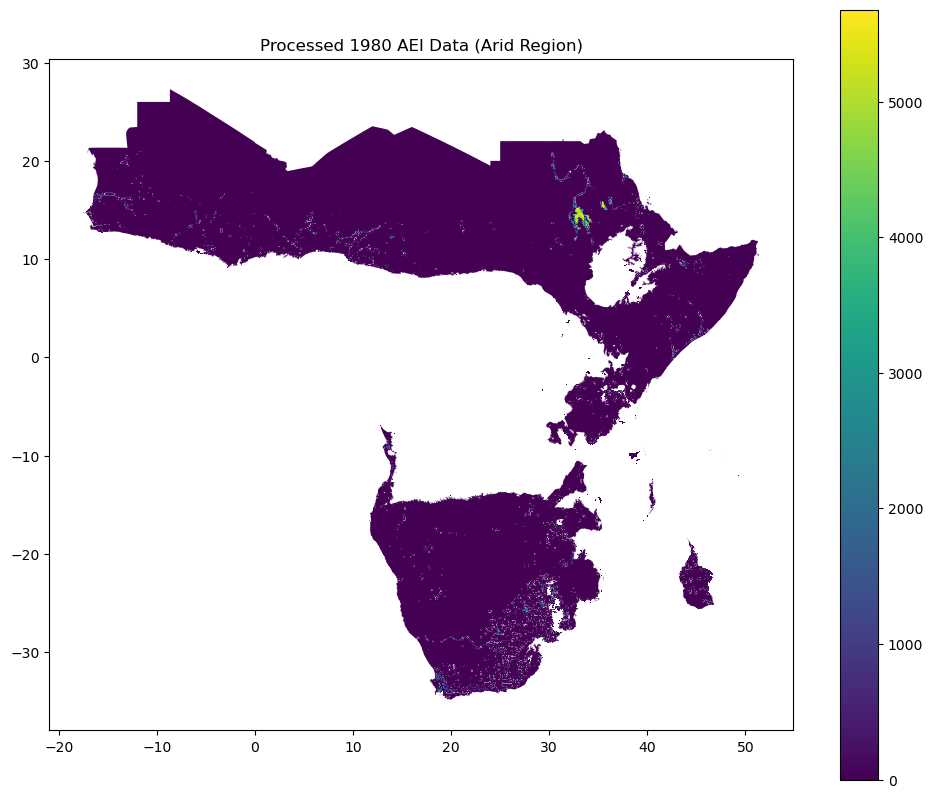

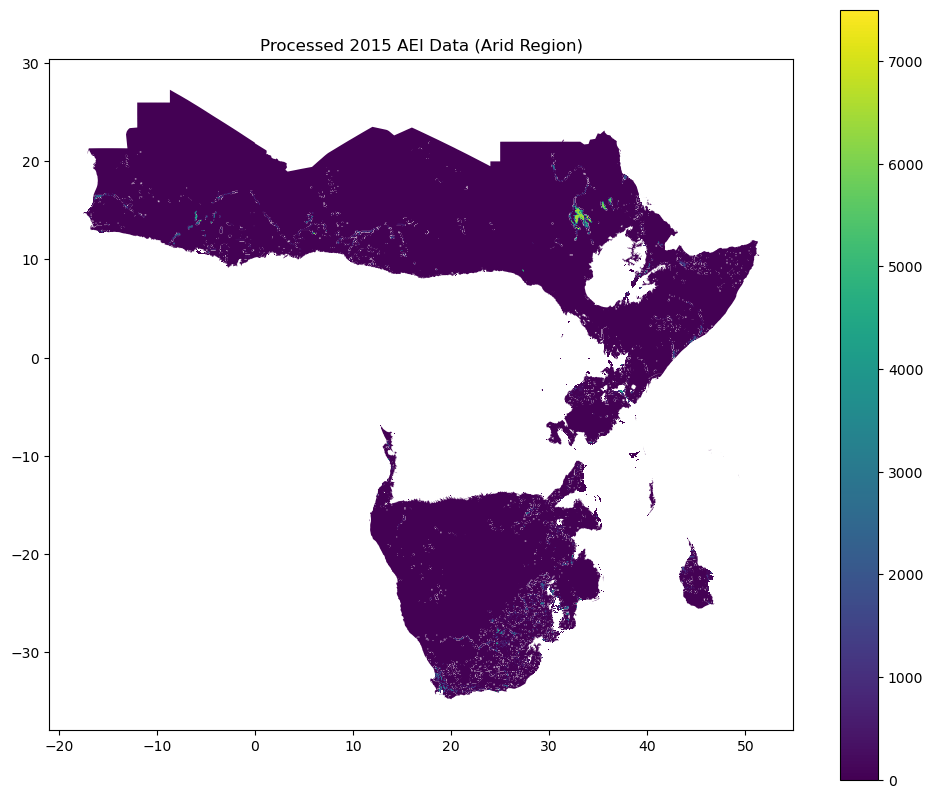

In [8]:
ax = gdf_cropped_asc_1980_arid.plot(column='raster_val', cmap='viridis', figsize=(12, 10), legend=True)
ax.set_title('Processed 1980 AEI Data (Arid Region)')
plt.show()

ax = gdf_cropped_asc_2015_arid.plot(column='raster_val', cmap='viridis', figsize=(12, 10), legend=True)
ax.set_title('Processed 2015 AEI Data (Arid Region)')
plt.show()